In [1]:
import sys
import os
from datetime import datetime
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import logging
from datetime import datetime
import traceback

from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, StratifiedKFold, LeaveOneOut
from sklearn.utils.multiclass import unique_labels

from sklearn.inspection import permutation_importance

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    RocCurveDisplay, auc, accuracy_score, precision_score, 
    recall_score, f1_score, confusion_matrix, classification_report,
    balanced_accuracy_score, roc_auc_score
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
import xgboost as xgb
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.feature_selection import SelectKBest, f_classif
import re
import scipy



pd.set_option('display.max_columns', None)

sys.path.append(os.path.abspath("../src"))  

def bold_max(df, dataset="", precision=2):
    """
    Return a Styler that bolds the column-wise maxima.

    Works with both:
    - numeric values
    - strings in the format '0.84 ± 0.02'

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with either numeric or 'mean ± std' strings.
    dataset : str
        A caption or title to display above the table.
    precision : int, default 2
        Number of decimals to show if numeric.
    """
    def is_string_with_std(val):
        return isinstance(val, str) and '±' in val
    
    def is_string_with_bracket(val):
        return isinstance(val, str) and '[' in val

    if df.applymap(is_string_with_std).all().all():
        # All cells are strings with ±
        def highlight_max(col):
            means = col.str.extract(r"(\d+\.\d+) ±")[0].astype(float)
            max_val = means.max()
            return ['font-weight: bold' if v == max_val else '' for v in means]

        return df.style.set_caption(f"Dataset: {dataset}").apply(highlight_max, axis=0)

    else:
        # Assume numeric DataFrame
        return (
            df.style
              .set_caption(f"Dataset: {dataset}")
              .format(f"{{:.{precision}f}}")
              .apply(lambda col: ['font-weight: bold' if v == col.max() else '' for v in col], axis=0)
        )


In [2]:
processed_path = '../data/processed/'
# Read data
df_digital_tmt_with_target = pd.read_csv(processed_path + 'df_digital_tmt_with_target.csv') 
demographic_df = pd.read_csv(processed_path + 'demographic_df.csv') 
non_digital_df = pd.read_csv(processed_path + 'non_digital_df.csv') 
df_digital_hand_and_eye = pd.read_csv(processed_path + 'df_digital_hand_and_eye.csv') 
digital_test_less_subjects = pd.read_csv(processed_path + 'digital_test_less_subjects.csv') 
non_digital_test_less_subjects = pd.read_csv(processed_path + 'non_digital_test_less_subjects.csv') 


# Final checks
print(df_digital_tmt_with_target['group'].value_counts())
print(demographic_df['group'].value_counts())
print(non_digital_df['group'].value_counts())
print(df_digital_hand_and_eye['group'].value_counts())
print(digital_test_less_subjects['group'].value_counts())
print(non_digital_test_less_subjects['group'].value_counts())

group
1    42
0    37
Name: count, dtype: int64
group
1    42
0    37
Name: count, dtype: int64
group
1    42
0    37
Name: count, dtype: int64
group
1    30
0    26
Name: count, dtype: int64
group
1    30
0    26
Name: count, dtype: int64
group
1    30
0    26
Name: count, dtype: int64


## Training

In [ ]:
# Configure logging
# Ensure logs folder exists
log_dir = "logs"
os.makedirs(log_dir, exist_ok=True)
# Create a fresh log file each run
log_filename = os.path.join(log_dir, f"error_log_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.log")
logging.basicConfig(filename=log_filename,
                    level=logging.ERROR,
                    format='%(asctime)s - %(levelname)s - %(message)s')


# ───────────────────────────────────────────────────────────────
# 0. SET-UP GENERAL 
# ───────────────────────────────────────────────────────────────
n_splits = 2
n_repeats = 1

global_seed = 42
inner_cv_seed = 50  # Fixed for reproducibility in inner CV
perform_pca = False
type_of_csv = 'loo'
n_components = 4
tune_hyperparameters = False
feature_selection = True

datasets = [
            # N=79
            'demographic', 
            'digital_test', 
            'demographic+digital',
            'non_digital_tests', 
            'non_digital_tests+demo',

            # N=56
            'demographic_less_subjects', 
            'digital_test_less_subjects', 
            'demographic+digital_less',
            'hand_and_eye',
            'hand_and_eye_demo',
            'non_digital_test_less_subjects', 
            'non_digital_test_less_subjects+demo'
            ]

# datasets = ['non_digital_test_less_subjects+demo']

for value in [True, False]:
    perform_pca = value
    for dataset in datasets:
        try:
            print(f"Starting {dataset}: \n\n")
            if perform_pca:
                print("Performing PCA")

            match dataset:
                case 'demographic':
                    X = demographic_df.iloc[:, :-1].values
                    y = demographic_df.iloc[:, -1].values
                    feature_names = demographic_df.columns[:-1]
                case 'demographic_less_subjects':  
                    X = demographic_df.loc[df_digital_hand_and_eye.index].iloc[:, :-1].values
                    y = demographic_df.loc[df_digital_hand_and_eye.index].iloc[:, -1].values
                    feature_names = demographic_df.loc[df_digital_hand_and_eye.index]  .columns[:-1]
                case 'demographic+digital':
                    df_digital_plus_demo = df_digital_tmt_with_target.join(demographic_df.drop('group',axis=1))
                    df_digital_plus_demo = df_digital_plus_demo[[col for col in df_digital_plus_demo.columns if col != 'group'] + ['group']]
                    X = df_digital_plus_demo.iloc[:, :-1].values
                    y = df_digital_plus_demo.iloc[:, -1].values
                    feature_names = df_digital_plus_demo.columns[:-1]
                case 'demographic+digital_less':
                    df_digital_plus_demo = df_digital_tmt_with_target.loc[df_digital_hand_and_eye.index].join(demographic_df.drop('group',axis=1))
                    df_digital_plus_demo = df_digital_plus_demo[[col for col in df_digital_plus_demo.columns if col != 'group'] + ['group']]
                    X = df_digital_plus_demo.iloc[:, :-1].values
                    y = df_digital_plus_demo.iloc[:, -1].values
                    feature_names = df_digital_plus_demo.columns[:-1]
                case 'non_digital_tests':
                    X = non_digital_df.iloc[:, :-1].values
                    y = non_digital_df.iloc[:, -1].values
                    feature_names = non_digital_df.columns[:-1]
                case 'non_digital_tests+demo':
                    df_non_digital_plus_demo = non_digital_df.join(demographic_df.drop('group',axis=1))
                    df_non_digital_plus_demo = df_non_digital_plus_demo[[col for col in df_non_digital_plus_demo.columns if col != 'group'] + ['group']]
                    X = df_non_digital_plus_demo.iloc[:, :-1].values
                    y = df_non_digital_plus_demo.iloc[:, -1].values
                    feature_names = df_non_digital_plus_demo.columns[:-1]
                case 'non_digital_test_less_subjects':
                    X = non_digital_test_less_subjects.iloc[:, :-1].values
                    y = non_digital_test_less_subjects.iloc[:, -1].values
                    feature_names = non_digital_test_less_subjects.columns[:-1]
                case 'non_digital_test_less_subjects+demo':
                    df_non_digital_less_plus_demo = non_digital_test_less_subjects.join(demographic_df.drop('group',axis=1))
                    df_non_digital_less_plus_demo = df_non_digital_less_plus_demo[[col for col in df_non_digital_less_plus_demo.columns if col != 'group'] + ['group']]
                    X = df_non_digital_less_plus_demo.iloc[:, :-1].values
                    y = df_non_digital_less_plus_demo.iloc[:, -1].values
                    feature_names = df_non_digital_less_plus_demo.columns[:-1]
                case 'digital_test':
                    X = df_digital_tmt_with_target.iloc[:, :-1].values
                    y = df_digital_tmt_with_target.iloc[:, -1].values
                    feature_names = df_digital_tmt_with_target.columns[:-1]
                case 'digital_test_less_subjects':
                    X = digital_test_less_subjects.iloc[:, :-1].values
                    y = digital_test_less_subjects.iloc[:, -1].values
                    feature_names = digital_test_less_subjects.columns[:-1]
                case 'hand_and_eye':
                    X = df_digital_hand_and_eye.iloc[:, :-1].values
                    y = df_digital_hand_and_eye.iloc[:, -1].values
                    feature_names = df_digital_hand_and_eye.columns[:-1]
                case 'hand_and_eye_demo': # hand + eye + demo
                    df_hand_eye_plus_demo = df_digital_hand_and_eye.join(demographic_df.drop('group',axis=1))
                    df_hand_eye_plus_demo = df_hand_eye_plus_demo[[col for col in df_hand_eye_plus_demo.columns if col != 'group'] + ['group']]
                    X = df_hand_eye_plus_demo.iloc[:, :-1].values
                    y = df_hand_eye_plus_demo.iloc[:, -1].values
                    feature_names = df_hand_eye_plus_demo.columns[:-1]
                case _:
                    raise ValueError(f'please select a valid dataset from: {datasets}')

            # ───────────────────────────────────────────────────────────────
            # 1. DEFINICIÓN DE PARÁMETROS Y MODELOS 
            # ───────────────────────────────────────────────────────────────

            unique, counts = np.unique(y, return_counts=True)
            print("Class distribution:", dict(zip(unique, counts)))

            # Define parameter grids
            param_grids = {
                "RandomForestClassifier": {
                    "classifier__n_estimators": [100, 500, 700, 1000],
                    "classifier__max_depth": [None, 10, 20, 30]
                },
                "SVC": {
                    "classifier__C": [0.1, 1, 10],
                    "classifier__kernel": ['linear', 'rbf']
                },
                "LogisticRegression": {
                    "classifier__C": [0.1, 1, 10],
                    "classifier__penalty": ['l2']
                },
                "XGBClassifier": {
                    "classifier__n_estimators": [100, 300],
                    "classifier__max_depth": [3, 5],
                    "classifier__learning_rate": [0.05, 0.1]
                }
            }

            # Define models to evaluate
            models = [
                RandomForestClassifier(random_state=42, n_jobs=-1),
                SVC(random_state=42, probability=True),
                LogisticRegression(max_iter=1000, random_state=42, solver='saga', n_jobs=-1),
                xgb.XGBClassifier(random_state=42, tree_method="hist", eval_metric='logloss',n_jobs=-1)
            ]

            # ───────────────────────────────────────────────────────────────
            # 2. Cross validation
            # ───────────────────────────────────────────────────────────────

            match type_of_csv:
                case 'stratified':
                    print(f"RepeatedStratifiedKFold selected with n_splits = {n_splits} and n_repeats = {n_repeats}")
                    outer_cv = RepeatedStratifiedKFold(
                        n_splits=n_splits,
                        n_repeats=n_repeats,         
                        random_state=global_seed # Global seed
                    )
                case 'loo':
                    print("LeaveOneOut selected")
                    outer_cv = LeaveOneOut()
                case _:
                    print("select a valid CV type")

            mean_fpr = np.linspace(0, 1, 100)
            all_metrics_df = pd.DataFrame(columns=[
                'model', 'repeat', 'fold',   
                'accuracy', 'balanced_accuracy', 'precision', 
                'recall', 'f1', 'auc', 'specificity'
            ])

            # ───────────────────────────────────────────────────────────────
            # 3. External loop 
            # ───────────────────────────────────────────────────────────────
            for model in models:
                model_name = model.__class__.__name__
                print(f"\n🧪 CV for: {model_name}")

                tprs, aucs, best_params_list, fold_metrics = [], [], [], []
                feature_importance_counts = {n: 0 for n in feature_names}

                # fig, ax = plt.subplots(figsize=(6, 6))
                all_y_true, all_y_pred = [], []

                # Enumeramos 'repeat' y 'fold' para guardar en métricas
                for outer_idx, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
                    n_features = 20
                    n_components = 4
                    fold = outer_idx  # index of the left-out observation
                    print('fold:', fold)

                    # ── Split
                    X_train, X_test = X[train_idx], X[test_idx]
                    y_train, y_test = y[train_idx], y[test_idx]

                    
                    # ── Inner CV: estratificado 3-fold con la MISMA semilla por repetición
                    inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=inner_cv_seed)
                    
                    if perform_pca:
                        n_components = min(n_components, X_train.shape[1])
                        print("n_components:", n_components)
                        pca_step = ('pca', PCA(n_components=n_components))
                    else:
                        pca_step = ('noop', 'passthrough')

                    
                    if feature_selection:
                        n_features = min(n_features, X_train.shape[1])
                        print("n_features:", n_features)
                        feature_selection_step = ('select', SelectKBest(score_func=f_classif, k=n_features))
                    else:
                        feature_selection_step = ('noop', 'passthrough')

                    pipeline = Pipeline([
                        ('imputer', SimpleImputer(strategy='mean')),  # or 'median' depending on your data
                        feature_selection_step,
                        ('scaler', StandardScaler()),
                        pca_step,
                        ('classifier', model)
                    ])

                    # Hiperparámetros
                    param_grid = param_grids.get(model_name, {})


                    if tune_hyperparameters and param_grid:
                        grid = GridSearchCV(
                            pipeline,
                            param_grid=param_grid,
                            cv=inner_cv,               
                            scoring='roc_auc',
                            n_jobs=-1,
                            verbose=0
                        )
                        grid.fit(X_train, y_train)
                        best_model = grid.best_estimator_
                        best_params_list.append(grid.best_params_)
                    else:
                        pipeline.fit(X_train, y_train)
                        best_model = pipeline
                        best_params_list.append("no tuning")

                    # ── Predicción
                    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
                    y_pred = best_model.predict(X_test)

                    all_y_true.extend(y_test)
                    all_y_pred.extend(y_pred)

                    fold_metrics.append({
                        'model': model_name,
                        'fold': fold,              
                        'y_test': y_test[0],
                        'y_pred': y_pred[0],
                        'y_pred_proba': y_pred_proba[0],
                        'feature_names': feature_names.values
                    })

                # ── Guardamos métricas
                all_metrics_df = pd.concat([all_metrics_df,
                                            pd.DataFrame(fold_metrics)],
                                        ignore_index=True)


            # save
            dir = f'./results/modelling/{datetime.now().strftime("%Y-%m-%d")}'
            os.makedirs(dir, exist_ok=True)
            if perform_pca:
                all_metrics_df.to_csv(f'{dir}/{dataset}_feature_{feature_selection}_n={n_features}_tune={tune_hyperparameters}_LOOCV_PCA_n_components{n_components}_{datetime.now().strftime("%s")[-4:]}.csv',index=False)
            else:
                all_metrics_df.to_csv(f'{dir}/{dataset}_feature_{feature_selection}_n={n_features}_tune={tune_hyperparameters}_LOOCV_{datetime.now().strftime("%s")[-4:]}.csv',index=False)
        except Exception as e:
            error_msg = traceback.format_exc().strip().split("\n")[-1]  # only last line of error
            logging.error(f"[{dataset}] PCA={perform_pca} → {error_msg}")
            print(f"⚠️ An error occurred with dataset {dataset}. Check log file: {log_filename}")


Starting demographic: 


Performing PCA
Class distribution: {0: 37, 1: 42}
LeaveOneOut selected

🧪 CV for: RandomForestClassifier
fold: 0
n_components: 3
n_features: 3
fold: 1
n_components: 3
n_features: 3
fold: 2
n_components: 3
n_features: 3
fold: 3
n_components: 3
n_features: 3
fold: 4
n_components: 3
n_features: 3
fold: 5
n_components: 3
n_features: 3
fold: 6
n_components: 3
n_features: 3
fold: 7
n_components: 3
n_features: 3
fold: 8
n_components: 3
n_features: 3
fold: 9
n_components: 3
n_features: 3
fold: 10
n_components: 3
n_features: 3
fold: 11
n_components: 3
n_features: 3
fold: 12
n_components: 3
n_features: 3
fold: 13
n_components: 3
n_features: 3
fold: 14
n_components: 3
n_features: 3
fold: 15
n_components: 3
n_features: 3
fold: 16
n_components: 3
n_features: 3
fold: 17
n_components: 3
n_features: 3
fold: 18
n_components: 3
n_features: 3
fold: 19
n_components: 3
n_features: 3
fold: 20
n_components: 3
n_features: 3
fold: 21
n_components: 3
n_features: 3
fold: 22
n_components:

In [11]:
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, balanced_accuracy_score

def calculate_metrics_leave_one_out(df, model_name, plot_roc=False):
    y_true = df[df['model'] == model_name]['y_test'].tolist()
    y_pred_proba = df[df['model'] == model_name]['y_pred_proba'].tolist()
    # y_pred = [1 if p >= 0.5 else 0 for p in y_pred_proba]  # Binarize
    y_pred = df[df['model'] == model_name]['y_pred'].tolist()

    try:
        auc = roc_auc_score(y_true, y_pred_proba)

    except ValueError:
        auc = np.nan

    return pd.DataFrame({
        'model': [model_name],
        'auc': [auc],
        'accuracy': [accuracy_score(y_true, y_pred)],
        'balanced_accuracy': [balanced_accuracy_score(y_true, y_pred)],
        'precision': [precision_score(y_true, y_pred, zero_division=0)],
        'recall': [recall_score(y_true, y_pred, zero_division=0)],
        'f1': [f1_score(y_true, y_pred, zero_division=0)],
        'y_true': [y_true],
        'y_pred_proba': [y_pred_proba],
    })



# Define the two directories
dir1 = Path('./results/modelling/2025-06-19')
dir2 = Path('./results/modelling/2025-06-13')

# Get all files recursively in both directories
files = list(dir1.rglob('*'))# + list(dir2.rglob('*'))

# Filter only files (exclude directories) and convert to absolute paths
file_paths = [f.resolve() for f in files if f.is_file()]

all_dataset_metrics = []
# Print or use the paths
for path in file_paths:
    print(path)
    pattern = re.compile(r"(.*?)_LOOCV")
    match = pattern.search(path.stem)
    dataset = match.group(1)
    print(dataset)

    all_metrics_df = pd.read_csv(path)
    model_dfs = [calculate_metrics_leave_one_out(all_metrics_df, model_name)
                for model_name in all_metrics_df['model'].unique()]

    metrics_global = pd.concat(model_dfs, ignore_index=True)
    metrics_global['dataset'] = dataset
    metrics_global['PCA'] = True if 'PCA' in str(path) else False
    metrics_global['features'] = True if 'feature' in str(path) else False
    metrics_global['complete'] = False if ('less' in str(path)) or ('eye' in str(path)) else True
    

    all_dataset_metrics.append(metrics_global)

/home/gus/Documents/REPOS/tmt-analysis/notebooks/results/modelling/2025-06-19/non_digital_test_less_subjects+demo_feature_True_n=15_tune=False_LOOCV_PCA_n_components4_3771.csv
non_digital_test_less_subjects+demo_feature_True_n=15_tune=False
/home/gus/Documents/REPOS/tmt-analysis/notebooks/results/modelling/2025-06-19/non_digital_test_less_subjects_feature_True_n=12_tune=False_LOOCV_PCA_n_components4_3754.csv
non_digital_test_less_subjects_feature_True_n=12_tune=False
/home/gus/Documents/REPOS/tmt-analysis/notebooks/results/modelling/2025-06-19/digital_test_feature_True_n=20_tune=False_LOOCV_3824.csv
digital_test_feature_True_n=20_tune=False
/home/gus/Documents/REPOS/tmt-analysis/notebooks/results/modelling/2025-06-19/hand_and_eye_demo_feature_True_n=20_tune=False_LOOCV_PCA_n_components4_3733.csv
hand_and_eye_demo_feature_True_n=20_tune=False
/home/gus/Documents/REPOS/tmt-analysis/notebooks/results/modelling/2025-06-19/non_digital_test_less_subjects+demo_feature_True_n=15_tune=False_LOO

In [12]:
all_datasets_df = pd.concat(all_dataset_metrics)

all_datasets_df.head(30)


# Create a new column with the base dataset name (strip everything after "_feature")
all_datasets_df['base_dataset'] = all_datasets_df['dataset'].apply(
    lambda x: re.split(r'_feature|_tune|_LOOCV', x)[0]
)

top1_per_dataset = all_datasets_df.groupby('base_dataset', group_keys=False).apply(
    lambda group: group.nlargest(1, 'auc')
)

top1_per_dataset = top1_per_dataset.sort_values('auc', ascending=False)#[['model', 'auc','PCA', 'base_dataset', 'complete']]

top1_per_dataset

,model,auc,accuracy,balanced_accuracy,precision,recall,f1,y_true,y_pred_proba,dataset,PCA,features,complete,base_dataset
2,LogisticRegression,0.861538,0.785714,0.784615,0.800000,0.800000,0.800000,"[1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, ...","[0.7836578964053217, 0.9635695616255298, 0.249...",non_digital_test_less_subjects+demo_feature_Tr...,True,True,False,non_digital_test_less_subjects+demo
2,LogisticRegression,0.852564,0.767857,0.767949,0.793103,0.766667,0.779661,"[1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, ...","[0.748883882649633, 0.9622343704431096, 0.3376...",non_digital_test_less_subjects_feature_True_n=...,True,True,False,non_digital_test_less_subjects
3,XGBClassifier,0.826823,0.732143,0.729167,0.774194,0.750000,0.761905,"[0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, ...","[0.0364810936152935, 0.7592764496803284, 0.977...",demographic+digital_less_feature_True_n=20_tun...,False,True,False,demographic+digital_less
2,LogisticRegression,0.788288,0.734177,0.735521,0.769231,0.714286,0.740741,"[0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, ...","[0.1226748318290022, 0.4130679992012541, 0.708...",non_digital_tests_feature_True_n=12_tune=False,True,True,True,non_digital_tests
1,SVC,0.778636,0.746835,0.745817,0.761905,0.761905,0.761905,"[0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, ...","[0.3336487722292252, 0.3569396551797666, 0.662...",non_digital_tests+demo_feature_True_n=15_tune=...,False,True,True,non_digital_tests+demo
1,SVC,0.712240,0.696429,0.666667,0.682927,0.875000,0.767123,"[0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, ...","[0.3694907968346878, 0.6524316530913943, 0.537...",demographic_less_subjects_feature_True_n=3_tun...,False,True,False,demographic_less_subjects
1,SVC,0.644788,0.645570,0.648970,0.694444,0.595238,0.641026,"[0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, ...","[0.2444942050229418, 0.6681773764425498, 0.298...",demographic+digital_feature_True_n=20_tune=False,False,True,True,demographic+digital
2,LogisticRegression,0.615187,0.607595,0.605212,0.627907,0.642857,0.635294,"[0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, ...","[0.2331110569463755, 0.7140240102614165, 0.265...",digital_test_feature_True_n=20_tune=False,False,True,True,digital_test
0,RandomForestClassifier,0.592949,0.589286,0.585897,0.612903,0.633333,0.622951,"[1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, ...","[0.27, 0.87, 0.55, 0.89, 0.65, 0.92, 0.23, 0.4...",hand_and_eye_demo_feature_True_n=20_tune=False,True,True,False,hand_and_eye_demo
0,RandomForestClassifier,0.564672,0.481013,0.479730,0.512195,0.500000,0.506024,"[0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, ...","[0.11, 0.7183333333333334, 0.2, 0.731666666666...",demographic_feature_True_n=3_tune=False,False,True,True,demographic


In [13]:
top1_per_dataset[top1_per_dataset['complete']].reset_index(drop=True)

,model,auc,accuracy,balanced_accuracy,precision,recall,f1,y_true,y_pred_proba,dataset,PCA,features,complete,base_dataset
0,LogisticRegression,0.788288,0.734177,0.735521,0.769231,0.714286,0.740741,"[0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, ...","[0.1226748318290022, 0.4130679992012541, 0.708...",non_digital_tests_feature_True_n=12_tune=False,True,True,True,non_digital_tests
1,SVC,0.778636,0.746835,0.745817,0.761905,0.761905,0.761905,"[0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, ...","[0.3336487722292252, 0.3569396551797666, 0.662...",non_digital_tests+demo_feature_True_n=15_tune=...,False,True,True,non_digital_tests+demo
2,SVC,0.644788,0.645570,0.648970,0.694444,0.595238,0.641026,"[0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, ...","[0.2444942050229418, 0.6681773764425498, 0.298...",demographic+digital_feature_True_n=20_tune=False,False,True,True,demographic+digital
3,LogisticRegression,0.615187,0.607595,0.605212,0.627907,0.642857,0.635294,"[0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, ...","[0.2331110569463755, 0.7140240102614165, 0.265...",digital_test_feature_True_n=20_tune=False,False,True,True,digital_test
4,RandomForestClassifier,0.564672,0.481013,0.479730,0.512195,0.500000,0.506024,"[0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, ...","[0.11, 0.7183333333333334, 0.2, 0.731666666666...",demographic_feature_True_n=3_tune=False,False,True,True,demographic


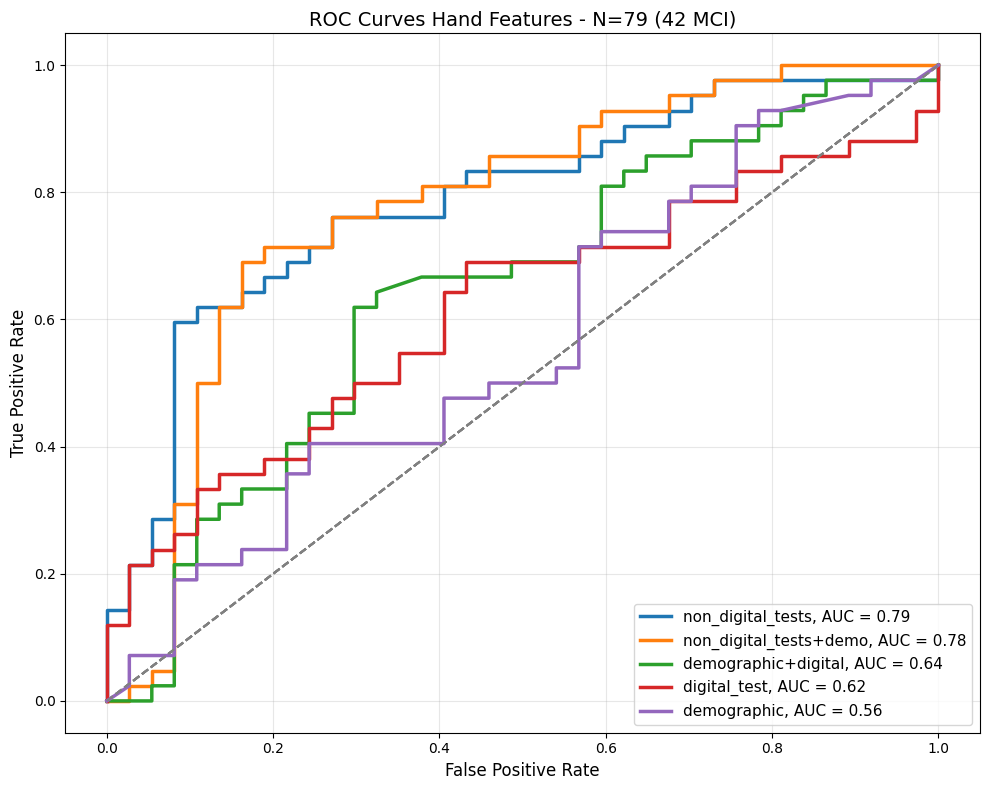

In [51]:
top1_per_dataset_complete = top1_per_dataset[top1_per_dataset['complete']]

colors = sns.color_palette("Set2", len(top1_per_dataset_complete))

plt.figure(figsize=(10, 8))


for idx, row in top1_per_dataset_complete.iterrows():
    y_true = row['y_true']
    y_pred_proba = row['y_pred_proba']
    
    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # Plot settings
    plt.plot(fpr, tpr, lw=2.5,
             label=f"{row['base_dataset']}, AUC = {round(roc_auc,2)}")
    
    plt.plot([0, 1], [0, 1], color='grey', lw=1.5, linestyle='--')

    # Titles and labels
    plt.title("ROC Curves Hand Features - N=79 (42 MCI)",
              fontsize=14)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.legend(loc='lower right', fontsize=11)
    plt.grid(alpha=0.3)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()


In [55]:
# Option 1: Ensure exact count
def permutation_test_auc(y_true, y_pred_proba, n_permutations=1000, seed=42):
    rng = np.random.RandomState(seed)
    true_auc = roc_auc_score(y_true, y_pred_proba)
    
    permuted_aucs = []
    attempts = 0
    max_attempts = n_permutations * 10  # Prevent infinite loop
    
    while len(permuted_aucs) < n_permutations and attempts < max_attempts:
        y_permuted = rng.permutation(y_true)
        try:
            perm_auc = roc_auc_score(y_permuted, y_pred_proba)
            permuted_aucs.append(perm_auc)
        except ValueError:
            pass  # Skip failed permutations
        attempts += 1
    
    if len(permuted_aucs) < n_permutations:
        print(f"Warning: Only {len(permuted_aucs)} valid permutations out of {n_permutations}")
    
    p_value = (np.sum(np.array(permuted_aucs) >= true_auc) + 1) / (len(permuted_aucs) + 1)
    return true_auc, p_value

for idx, row in top1_per_dataset[top1_per_dataset['complete']].iterrows():
    y_true = np.array(row['y_true'])
    y_proba = np.array(row['y_pred_proba'])

    auc, p_val = permutation_test_auc(y_true, y_proba, n_permutations=1000)
    print(f"{row['model']} on {row['base_dataset']} → AUC = {auc:.3f}, p = {p_val:.4f}")


LogisticRegression on non_digital_tests → AUC = 0.788, p = 0.0010
SVC on non_digital_tests+demo → AUC = 0.779, p = 0.0010
SVC on demographic+digital → AUC = 0.645, p = 0.0170
LogisticRegression on digital_test → AUC = 0.615, p = 0.0490
RandomForestClassifier on demographic → AUC = 0.565, p = 0.1728


In [14]:
top1_per_dataset[~top1_per_dataset['complete']].reset_index(drop=True)

,model,auc,accuracy,balanced_accuracy,precision,recall,f1,y_true,y_pred_proba,dataset,PCA,features,complete,base_dataset
0,LogisticRegression,0.861538,0.785714,0.784615,0.800000,0.800000,0.800000,"[1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, ...","[0.7836578964053217, 0.9635695616255298, 0.249...",non_digital_test_less_subjects+demo_feature_Tr...,True,True,False,non_digital_test_less_subjects+demo
1,LogisticRegression,0.852564,0.767857,0.767949,0.793103,0.766667,0.779661,"[1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, ...","[0.748883882649633, 0.9622343704431096, 0.3376...",non_digital_test_less_subjects_feature_True_n=...,True,True,False,non_digital_test_less_subjects
2,XGBClassifier,0.826823,0.732143,0.729167,0.774194,0.750000,0.761905,"[0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, ...","[0.0364810936152935, 0.7592764496803284, 0.977...",demographic+digital_less_feature_True_n=20_tun...,False,True,False,demographic+digital_less
3,SVC,0.712240,0.696429,0.666667,0.682927,0.875000,0.767123,"[0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, ...","[0.3694907968346878, 0.6524316530913943, 0.537...",demographic_less_subjects_feature_True_n=3_tun...,False,True,False,demographic_less_subjects
4,RandomForestClassifier,0.592949,0.589286,0.585897,0.612903,0.633333,0.622951,"[1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, ...","[0.27, 0.87, 0.55, 0.89, 0.65, 0.92, 0.23, 0.4...",hand_and_eye_demo_feature_True_n=20_tune=False,True,True,False,hand_and_eye_demo
5,LogisticRegression,0.530769,0.500000,0.497436,0.533333,0.533333,0.533333,"[1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, ...","[0.284397643654871, 0.839603343565816, 0.22497...",hand_and_eye_feature_True_n=20_tune=False,True,True,False,hand_and_eye
6,XGBClassifier,0.511538,0.535714,0.533333,0.566667,0.566667,0.566667,"[1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, ...","[0.6866195201873779, 0.2701362371444702, 0.970...",digital_test_less_subjects_feature_True_n=20_t...,True,True,False,digital_test_less_subjects


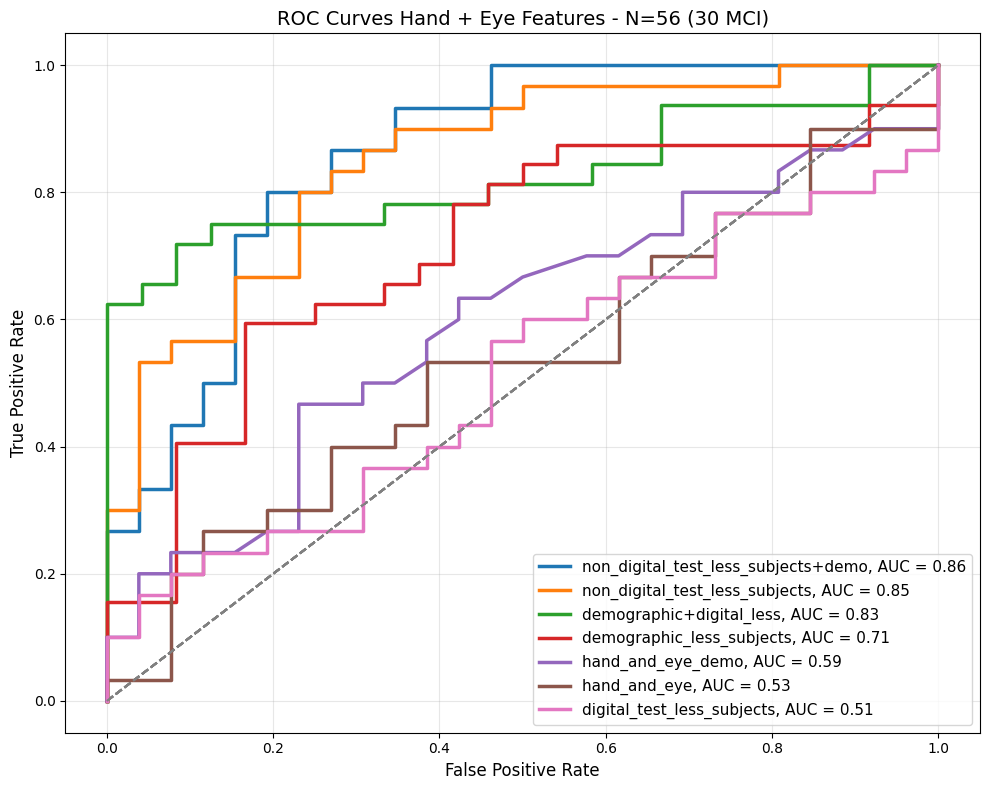

In [53]:
top1_per_dataset_incomplete = top1_per_dataset[~top1_per_dataset['complete']]

colors = sns.color_palette("Set2", len(top1_per_dataset_incomplete))

plt.figure(figsize=(10, 8))


for idx, row in top1_per_dataset_incomplete.iterrows():
    y_true = row['y_true']
    y_pred_proba = row['y_pred_proba']
    
    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # Plot settings
    plt.plot(fpr, tpr, lw=2.5,
             label=f"{row['base_dataset']}, AUC = {round(roc_auc,2)}")
    
    plt.plot([0, 1], [0, 1], color='grey', lw=1.5, linestyle='--')

    # Titles and labels
    plt.title("ROC Curves Hand + Eye Features - N=56 (30 MCI)",
              fontsize=14)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.legend(loc='lower right', fontsize=11)
    plt.grid(alpha=0.3)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()


In [56]:
top1_per_dataset_incomplete = top1_per_dataset[~top1_per_dataset['complete']]

for idx, row in top1_per_dataset_incomplete.iterrows():
    y_true = np.array(row['y_true'])
    y_proba = np.array(row['y_pred_proba'])

    auc, p_val = permutation_test_auc(y_true, y_proba, n_permutations=1000)
    print(f"{row['model']} on {row['base_dataset']} → AUC = {auc:.3f}, p = {p_val:.4f}")

LogisticRegression on non_digital_test_less_subjects+demo → AUC = 0.862, p = 0.0010
LogisticRegression on non_digital_test_less_subjects → AUC = 0.853, p = 0.0010
XGBClassifier on demographic+digital_less → AUC = 0.827, p = 0.0010
SVC on demographic_less_subjects → AUC = 0.712, p = 0.0030
RandomForestClassifier on hand_and_eye_demo → AUC = 0.593, p = 0.0949
LogisticRegression on hand_and_eye → AUC = 0.531, p = 0.3317
XGBClassifier on digital_test_less_subjects → AUC = 0.512, p = 0.4296


In [ ]:
import re

# 1. Extract base dataset name (e.g., remove _feature, _tune, etc.)
all_datasets_df['base_dataset'] = all_datasets_df['dataset'].apply(
    lambda x: re.split(r'_feature|_tune|_LOOCV|_PCA', x)[0]
)

# 2. Select the row with the highest AUC for each base dataset
best_model_per_base_dataset = (
    all_datasets_df.loc[
        all_datasets_df.groupby('base_dataset')['auc'].idxmax()
    ]
    .reset_index(drop=True)
)

# 3. Optional: drop the helper column if not needed
# best_model_per_base_dataset = best_model_per_base_dataset.drop(columns=['base_dataset'])

# Display the result
best_model_per_base_dataset


In [ ]:
import re

# Create a new column with the base dataset name (strip everything after "_feature")
all_datasets_df['base_dataset'] = all_datasets_df['dataset'].apply(
    lambda x: re.split(r'_feature|_tune|_LOOCV', x)[0]
)

# Now select the best model per base dataset (ignoring PCA or other options)
best_model_per_base_dataset = all_datasets_df.loc[
    all_datasets_df.groupby('base_dataset')['auc'].idxmax()
].reset_index(drop=True)

best_model_per_base_dataset[['model', 'auc','PCA', 'base_dataset']]


In [ ]:
top1_per_dataset[~top1_per_dataset['PCA']].sort_values('auc', ascending=False)

In [118]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

def plot_model_metrics(path):
    all_metrics_df = pd.read_csv(path)

    # Extraer nombre del dataset
    match = re.search(r"(?<=all_metrics_).*(?=_nested4x10\.csv)", path)
    dataset = match.group() if match else "unknown"
    print("Dataset name:", dataset)

    # Tabla de medias por modelo
    metrics_comparison = all_metrics_df.groupby('model').mean(numeric_only=True)
    # display(bold_max(metrics_comparison, dataset=dataset))

    # Crear tabla con formato "mean [min max]" por modelo y métrica
    metrics_to_plot = ['balanced_accuracy', 'precision', 'recall', 'f1', 'auc']
    summary_formatted = []

    for model in all_metrics_df['model'].unique():
        row = {'model': model}
        df_model = all_metrics_df[all_metrics_df['model'] == model]
        for metric in metrics_to_plot:
            mean_val = df_model[metric].mean()
            min_val = df_model[metric].min()
            max_val = df_model[metric].max()
            row[metric] = f"{mean_val:.3f} [{min_val:.3f} {max_val:.3f}]"
        summary_formatted.append(row)

    formatted_df = pd.DataFrame(summary_formatted)
    print("\nResumen de métricas por modelo (mean [min max]):")
    display(formatted_df)

    # Boxplot
    df_long = all_metrics_df.melt(
        id_vars=['model', 'repeat', 'fold'],
        value_vars=metrics_to_plot,
        var_name='metric',
        value_name='score'
    )

    plt.figure(figsize=(14, 6))
    sns.boxplot(
        data=df_long,
        x='metric',
        y='score',
        hue='model',
        linewidth=1.5
    )

    formatted_df['dataset'] = dataset
    plt.axhline(0.5, color='gray', linestyle='--', linewidth=1.4)
    plt.title(f'Distribución de métricas para el dataset "{dataset}"', fontsize=16)
    plt.xlabel('Métrica', fontsize=14)
    plt.ylabel('Score', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(title='Modelo', fontsize=10, title_fontsize=8, loc='best', bbox_to_anchor=(0, 0, 1, 1))
    plt.tight_layout()
    plt.show()

    return formatted_df


In [ ]:
dfs_results = []
for dataset in ['pca', 'demographic', 'digital_test', 'demographic+digital', 'hand_and_eye', 'non_digital_tests', 'digital_test_less_subjects', 'hand_and_eye_demo']:
    df_res = plot_model_metrics(f'/home/gus/Documents/REPOS/tmt-analysis/notebooks/results/modelling/resultados_seminario_06_06_25/all_metrics_{dataset}_nested4x10.csv')
    dfs_results.append(df_res)